# Colorado cannabis sales data 🌳 🚬

Every month, the Colorado Department of Revenue [publishes](https://www.colorado.gov/pacific/revenue/colorado-marijuana-sales-reports) county-level data on retail and medical cannabis sales in the state.

This notebook is intended to show various things you might do in the course of gathering and analyzing data, maybe in a newsroom. It has code to:
- Download the raw .xlsx files into the `raw-data` directory
- Parse these files into flat CSVs in the `processed-data` directory
- Load the CSV data into a `pandas` dataframe for analysis (and write out to one big stacked CSV: `./co-cannabis-sales.csv`)
- Download the Census TIGER/LINE shapefile of Colorado counties into the `raw-data` directory
- Load this shapefile into `geopandas`
- Hit the Census Bureau API to get 2017 population estimates for Colorado counties
- Draw a choropleth map with per-capita sales data by county

### Prerequisites

If you don't have one already, [grab an API key from the Census Bureau](https://www.census.gov/data/developers/guidance/api-user-guide.Query_Components.html) and save it as an [environmental variable](https://en.wikipedia.org/wiki/Environment_variable) called `CENSUS_API_KEY`.

### Import dependencies

In [1]:
import os
import glob
import time
from datetime import date
import csv
import zipfile

import requests
from bs4 import BeautifulSoup
from openpyxl import load_workbook
import pandas as pd
import geopandas as gpd
from matplotlib.ticker import FuncFormatter

In [2]:
# display plots inline
%matplotlib inline

# display floats with thousand-separator commas and no decimal points
pd.options.display.float_format = '{:,.0f}'.format

### A function to download the spreadsheets

This function fetches the page, extracts the relevant `.xlsx` links, checks to see which ones we already have, and downloads the ones we don't.

In [3]:
def download_pot_data():
    '''Fetch a current list of .xlsx files on the CO marijuana sales reports page
    and download the ones we do not have already.'''
    
    # get a list of files that already exist in the `raw-data` directory
    raw_files = glob.glob(os.path.join('raw-data', '*.xlsx'))
    
    # the URL of the page with the links to the monthly sales reports
    url = 'https://www.colorado.gov/pacific/revenue/colorado-marijuana-sales-reports'
    
    # fetch the main page
    r = requests.get(url)
    
    # turn it into soup
    soup = BeautifulSoup(r.text, 'html.parser')
    
    # find all `a` tags with "xlsx" in the href attribute but not "CalendarReport"
    sheets = soup.find_all('a', href=lambda x: x and 'xlsx' in x and 'CalendarReport' not in x)
    
    # list comprehension to get just the hrefs from that list
    to_dl = [x['href'] for x in sheets]
    
    # list comprehension to get the names of the files we already have
    already_there = [x.split('/')[-1] for x in raw_files]
    
    # loop over the list of spreadsheet links to download
    for link in to_dl:
        
        # the name of the file to save locally is the last bit of the URL
        fname = link.split('/')[-1]
        
        # see if we've already got that file
        if fname not in already_there:
            
            # if not, join the destination directory to the filename
            dest = os.path.join('raw-data/', fname)
            
            # print to let us know it's working
            print(dest)
            
            # fetch that file ...
            r = requests.get(link, stream=True)
            
            # and write it file on this computer
            with open(dest, 'wb') as f:
                
                # iterating a bit at a time over blocks of the file
                # http://docs.python-requests.org/en/master/api/#requests.Response.iter_content
                for block in r.iter_content(1024):
                    f.write(block)

            # pause for 2 seconds before continuing
            time.sleep(2)

In [4]:
# run the download function
download_pot_data()

raw-data/0718_MarijuanaSalesReport%20PUBLISH.xlsx


### A function to extract the data from the sheets

This one's a little messy. The spreadsheet data is laid out in adjacent tables of varying length -- one for medical sales, one for retail.

![sheet layout](img/sheet-layout.png "Sheet layout")

- Every row in the data is the sum of one month of sales for one category of cannabis ("retail" or "medical") for one county
- Not every county in Colorado has pot shops
- To maintain taxpayer privacy, the state releases aggregate sales data only for counties with at least three dispensaries, and then only if none represent more than 80 percent of total sales, according to the state. Totals for counties that don't meet these criteria are represented in the data as "NR" -- we'll replace these with `None` -- and the total for these "NR" counties is represented in a separate record labeled "Sum of NR Counties"

There's probably a fancy way to handle all this in pandas but I went with `openpyxl` and a stop/go flag to manage data collection.

In [5]:
def extract_pot_data(xlsx_filename):
    '''Given a monthly marijuan sales report, extract the data and return a tuple
    with the CSV filename (YYYYMM.csv) and the data as a list'''

    # get the bare filename, without directories
    filename = xlsx_filename.split('/')[-1]
    
    # the first bit of the filename is the year and month
    namesplit = filename.split('_')[0]
    month, year = namesplit[0:2], '20' + namesplit[2:4]
    fname = '{year}{month}.csv'.format(year=year, month=month)
    
    # load the workbook with openpyxl
    wb = load_workbook(xlsx_filename)
    ws = wb.active

    # a list to hold the data
    out = []
    
    # a flag to manage whether to start collecting data as we iterate over the rows
    go = False
    
    # iterate over the worksheet rows
    for x in ws.iter_rows():
        
        # check if there's a value in cell of the first column
        if x[0].value:
            
            # get a casefolded version of that value
            first = x[0].value.casefold()
            
            # if we're at the "Total" line, we're done
            if first.startswith('total'):
                go = False
                break
            
            # if we're at the row with MMJ sales, flip the `go` flag and start collecting data
            if first.startswith('medical marijuana sales'):
                go = True
                continue
            
            # if we're in collection mode, get the data
            if go:
                
                # list comprehension to get the values in this row
                row = [z.value for z in x]
                
                # ignore the header row and some garbage over-wrapped rows
                if not row[0].startswith(('Sales', 'County')):
                    
                    # extract counties and totals for both rec and medical tables
                    mc, mt, _, rc, rt, *rest = row
                    
                    # make sure there are values, and double-check that
                    # we're not at the summary row
                    if mc and mt and not mc.startswith('Total'):
                        # some cleanup on the "Sum of NR Counties" row
                        mc = mc.replace('Counties 4', 'Counties')
                        
                        # replacing their bespoke "no value" value with None
                        if mt == 'NR':
                            mt = None
                        
                        # add this to the outlist
                        out.append([month, year, mc, mt, 'medical'])
                    
                    # repeat this process for recreational totals
                    if rc and rt and not rc.startswith('Total'):
                        rc = rc.replace('Counties 4', 'Counties')
                        if rt == 'NR':
                            rt = None
                        out.append([month, year, rc, rt, 'retail'])

    # return a tuple with filename and data
    return (fname, out)

### Loop over the spreadsheets and write to CSVs

In [6]:
# get a list of raw files again, now that we've run the download function
raw_files = glob.glob(os.path.join('raw-data', '*.xlsx'))

# specify the headers on our CSV files
headers = ['month', 'year', 'county', 'amount', 'sales_type']

In [7]:
# loop over the xlsx files we downloaded
for f in raw_files:

    # call the `extract_pot_data` function on the sheet
    # and assign filename and data variables
    fname, data = extract_pot_data(f)
    
    # build path to the CSV we're creating
    dest = os.path.join('processed-data', fname)
    
    # open that file to write to
    with open (dest, 'w') as o:
        
        # create a csv writer object
        writer = csv.writer(o)
        
        # write the headers
        writer.writerow(headers)
        
        # write the data
        writer.writerows(data)

### Load the CSVs into a dataframe

In [8]:
# get a list of the CSV files we just created
processed_files = glob.glob(os.path.join('processed-data', '20*.csv'))

In [9]:
# create a dataframe by concatenating dataframes in a list comprehension
# solution via googling "pandas read_csv multiple files" =>
# https://stackoverflow.com/questions/20906474/import-multiple-csv-files-into-pandas-and-concatenate-into-one-dataframe#comment57648172_21232849
df = pd.concat([pd.read_csv(f) for f in processed_files])

In [10]:
df.head()

,month,year,county,amount,sales_type
0,4,2016,Adams,"387,146",medical
1,4,2016,Adams,"3,187,313",retail
2,4,2016,Alamosa,nan,medical
3,4,2016,Arapahoe,"7,531,661",retail
4,4,2016,Arapahoe,"1,682,301",medical


In [11]:
# save this stacked dataframe to file
df.to_csv('co-cannabis-sales.csv', index=False)

In [12]:
# check month values
sorted(df.month.unique())

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

In [13]:
# check year values
sorted(df.year.unique())

[2014, 2015, 2016, 2017, 2018]

In [14]:
# check county values
sorted(df.county.unique())

['Adams',
 'Alamosa',
 'Arapahoe',
 'Archuleta',
 'Boulder',
 'Chaffee',
 'Clear Creek',
 'Conejos',
 'Costilla',
 'Denver',
 'Eagle',
 'El Paso',
 'Fremont',
 'Garfield',
 'Gilpin',
 'Grand',
 'Gunnison',
 'Huerfano',
 'Jefferson',
 'La Plata',
 'Lake',
 'Larimer',
 'Las Animas',
 'Mesa',
 'Moffat',
 'Montezuma',
 'Montrose',
 'Morgan',
 'Otero',
 'Ouray',
 'Park',
 'Pitkin',
 'Pueblo',
 'Routt',
 'Saguache',
 'San Juan',
 'San Miguel',
 'Sedgwick',
 'Sum of NR Counties',
 'Summit',
 'Teller',
 'Weld']

In [15]:
# check type values
df.sales_type.unique()

array(['medical', 'retail'], dtype=object)

In [16]:
# create a date column to group by later when we plot
df['date'] = df.apply(lambda x: date(x.year, x.month, 1), axis=1)

In [17]:
# create filtered dataframes for medical and retail data
retail = df[df.sales_type == 'retail']
med = df[df.sales_type == 'medical']

### Do some basic analysis

In [18]:
# sum
df.amount.sum()

5320467150.0

In [19]:
# sum by year
df[['year', 'amount']].groupby('year').sum()

,amount
year,
2014,"683,523,739"
2015,"995,591,255"
2016,"1,307,203,473"
2017,"1,502,047,770"
2018,"832,100,913"


In [20]:
# sum by county by year
pd.pivot_table(df,
               index='county',
               values='amount',
               columns='year',
               aggfunc=sum)

year,2014,2015,2016,2017,2018
county,,,,,
Adams,"8,531,797","24,826,654","49,810,527","73,319,607","50,193,741"
Alamosa,0,0,0,0,0
Arapahoe,"19,083,212","68,533,185","113,890,135","124,313,953","73,625,627"
Archuleta,0,0,0,"6,397,396","4,964,040"
Boulder,"62,935,522","82,465,474","95,408,126","99,923,326","61,033,590"
Chaffee,"438,160","2,067,869","3,492,699","5,422,335","3,303,971"
Clear Creek,"6,095,765","6,435,080","7,414,079","7,262,477","4,433,550"
Conejos,nan,0,"3,522,183","5,426,288","3,369,025"
Costilla,0,0,"2,836,421","3,874,954","2,309,877"


### Let's make a line chart

Specifically, let's replicate the line chart from the state webpage:

![official chart](img/mjsales.jpg "Official chart")

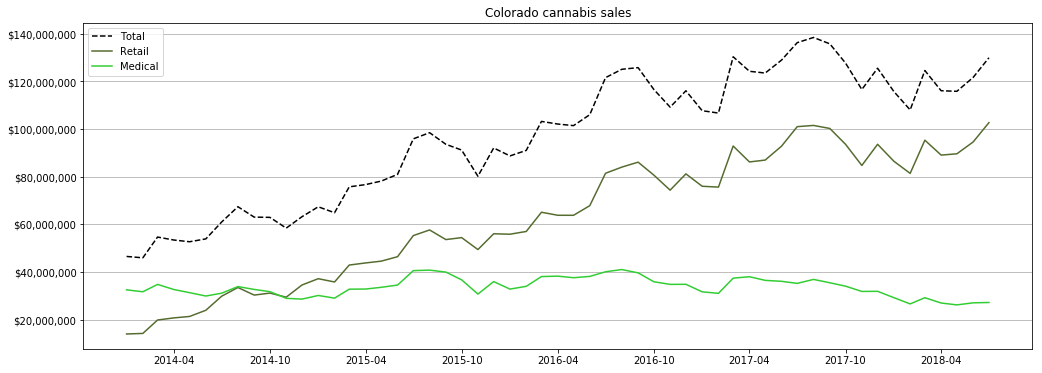

In [21]:
# chart totals by month, each type

# groupby objects for total, medical and retail dataframes
total_grouped = df[['date', 'amount']].groupby('date').sum()
med_grouped = med[['date', 'amount']].groupby('date').sum()
retail_grouped = retail[['date', 'amount']].groupby('date').sum()

# start with totals to create the chart
linechart = total_grouped.plot(color='black',
                               figsize=(17, 6),
                               title='Colorado cannabis sales',
                               linestyle='--')

# plot retail
retail_grouped.plot(ax=linechart, color='DarkOliveGreen')

# plot medical
med_grouped.plot(ax=linechart, color='LimeGreen')

# set the legend
linechart.legend(['Total', 'Retail', 'Medical'])

# turn major gridlines on
linechart.grid(True, which='major', axis='y')

# blank axis labels -- seems like it's implied?
linechart.set_xlabel('')
linechart.set_ylabel('')

# format y axis values
linechart.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '${:,.0f}'.format(y))) 

### A function to download a GIS file of Colorado counties

In [22]:
def get_co_county_gis_data():
    '''download a zipped shapefile of Colorado counties'''

    url = 'https://www2.census.gov/geo/tiger/TIGER2010/COUNTY/2000/tl_2010_08_county00.zip'
    fname = os.path.join('raw-data', url.split('/')[-1])    
    
    # if it's not here already ...
    if not os.path.isfile(fname):
        
        # fetch it
        r = requests.get(url)

        # and write it to file
        with open(fname, 'wb') as f:

            for block in r.iter_content(1024):
                f.write(block)

    return fname

In [23]:
# fetch the GIS data and assign what's returned (the filename) to a variable
geodata = get_co_county_gis_data()

# unzip the file
with zipfile.ZipFile(geodata, 'r') as z:
    z.extractall('raw-data')

### Load the GIS data into geopandas

In [24]:
# the shapefile naming convention is the same, so get the root filename + '.shp'
shp = geodata.split('.zip')[0] + '.shp'

# and load it into a geodataframe
gdf = gpd.read_file(shp)

In [25]:
gdf.head()

,STATEFP00,COUNTYFP00,CNTYIDFP00,NAME00,NAMELSAD00,LSAD00,CLASSFP00,MTFCC00,UR00,FUNCSTAT00,ALAND00,AWATER00,INTPTLAT00,INTPTLON00,geometry
0,08,013,08013,Boulder,Boulder County,06,H1,G4020,M,A,1908733293,36715760,+40.0866321,-105.3590729,"POLYGON ((-105.16615 39.914047, -105.166565 39..."
1,08,069,08069,Larimer,Larimer County,06,H1,G4020,M,A,6723614521,98295250,+40.6630912,-105.4821309,"POLYGON ((-105.05672 40.349281, -105.056699 40..."
2,08,071,08071,Las Animas,Las Animas County,06,H1,G4020,M,A,12361162110,6929979,+37.3188308,-104.0441103,"POLYGON ((-104.143179 37.75833, -104.126149 37..."
3,08,043,08043,Fremont,Fremont County,06,H1,G4020,M,A,3970618782,2235223,+38.4556576,-105.4214383,"POLYGON ((-105.368889 38.25939899999999, -105...."
4,08,041,08041,El Paso,El Paso County,06,H1,G4020,M,A,5508385644,7111582,+38.8273831,-104.5274718,"POLYGON ((-104.938986 38.792013, -104.938977 3..."


### Grab population data from the Census

In [26]:
# grab environmental variable with API key
census_api_key = os.environ.get('CENSUS_API_KEY')

In [27]:
def get_county_pop():
    
    # endpoint for 2017 population estimates
    endpoint = 'https://api.census.gov/data/2017/pep/population'

    # URL parameters to target info we want
    params = {
        'get': 'GEONAME,POP',
        'for': 'county:*',
        'in': 'state:08',
        'key': census_api_key
    }

    # request data from the API
    r = requests.get(endpoint, params=params)
    r.raise_for_status()
    
    # turn the response into Python data objects
    j = r.json()
    
    # get the headers from the first record
    headers = j[0]
    
    # return a dict of the list of data
    return [dict(zip(headers, x)) for x in j[1:]]

In [28]:
cpop = get_county_pop()

In [29]:
popfile = os.path.join('processed-data', 'colorado-county-pop-estimates-2017.csv')

# write out population data to file
with open(popfile, 'w') as o:
    headers = list(cpop[0].keys())
    writer = csv.DictWriter(o, fieldnames=headers)
    writer.writeheader()
    writer.writerows(cpop)

In [30]:
# read the data into a dataframe, preserving the FIPS codes as strings
pop_df = pd.read_csv(popfile,
                     dtype={'state': str, 'county': str, 'POP': float})

In [31]:
pop_df.head()

,GEONAME,POP,state,county
0,"Adams County, Colorado","503,167",08,001
1,"Alamosa County, Colorado","16,551",08,003
2,"Arapahoe County, Colorado","643,052",08,005
3,"Archuleta County, Colorado","13,315",08,007
4,"Baca County, Colorado","3,562",08,009


In [32]:
# combine county and state FIPS
pop_df['fips'] = pop_df['state'] + pop_df['county']

In [33]:
pop_df.head()

,GEONAME,POP,state,county,fips
0,"Adams County, Colorado","503,167",08,001,08001
1,"Alamosa County, Colorado","16,551",08,003,08003
2,"Arapahoe County, Colorado","643,052",08,005,08005
3,"Archuleta County, Colorado","13,315",08,007,08007
4,"Baca County, Colorado","3,562",08,009,08009


### Map: Per-capita sales analysis

We'll look at 2017 retail sales data -- [checking this researcher's work, basically](https://www.thecannabist.co/2018/02/09/colorado-marijuana-sales-southern-border/98669/). Our steps:

1. Merge our GIS dataframe with the population data
2. Merge the result with the cannabis sales data
3. Calculate the per-capita rate
4. Plot on a map

In [34]:
geo_pop_df = pd.merge(gdf,
                      pop_df,
                      how='left',
                      left_on='CNTYIDFP00',
                      right_on='fips')[['fips', 'NAME00', 'geometry', 'POP']]

In [35]:
geo_pop_df.head()

,fips,NAME00,geometry,POP
0,08013,Boulder,"POLYGON ((-105.16615 39.914047, -105.166565 39...","322,514"
1,08069,Larimer,"POLYGON ((-105.05672 40.349281, -105.056699 40...","343,976"
2,08071,Las Animas,"POLYGON ((-104.143179 37.75833, -104.126149 37...","14,238"
3,08043,Fremont,"POLYGON ((-105.368889 38.25939899999999, -105....","47,559"
4,08041,El Paso,"POLYGON ((-104.938986 38.792013, -104.938977 3...","699,232"


In [36]:
# filter to get 2017 retail sales data
r17 = retail[retail['year'] == 2017]

In [37]:
# group by county and sum the amounts
r17_group = r17[['county', 'amount']].groupby('county').sum().reset_index()

In [38]:
# merge that with the dataframe we merged earlier
retail_17_map = pd.merge(geo_pop_df,
                         r17_group,
                         how='left',
                         left_on='NAME00',
                         right_on='county')[['fips', 'NAME00', 'geometry', 'POP', 'amount']]

In [39]:
retail_17_map.head()

,fips,NAME00,geometry,POP,amount
0,08013,Boulder,"POLYGON ((-105.16615 39.914047, -105.166565 39...","322,514","77,438,466"
1,08069,Larimer,"POLYGON ((-105.05672 40.349281, -105.056699 40...","343,976","58,391,921"
2,08071,Las Animas,"POLYGON ((-104.143179 37.75833, -104.126149 37...","14,238","43,913,648"
3,08043,Fremont,"POLYGON ((-105.368889 38.25939899999999, -105....","47,559",nan
4,08041,El Paso,"POLYGON ((-104.938986 38.792013, -104.938977 3...","699,232",0


In [40]:
# calculate the per-capita rate
retail_17_map['per_capita'] = retail_17_map['amount'] / retail_17_map['POP']

In [41]:
retail_17_map.sort_values('per_capita', ascending=False).head()

,fips,NAME00,geometry,POP,amount,per_capita
2,08071,Las Animas,"POLYGON ((-104.143179 37.75833, -104.126149 37...","14,238","43,913,648","3,084"
24,08023,Costilla,"POLYGON ((-105.738409 37.30676, -105.73842 37....","3,776","3,874,954","1,026"
44,08091,Ouray,"POLYGON ((-107.955652 38.226491, -107.956589 3...","4,794","3,916,922",817
29,08083,Montezuma,"POLYGON ((-109.045831 37.32684, -109.045837 37...","26,140","20,163,593",771
11,08117,Summit,"POLYGON ((-106.177604 39.609056, -106.177583 3...","30,585","22,904,938",749


/Users/codywinchester/.virtualenvs/co-weed-sales-data-IA-8h5qX/lib/python3.6/site-packages/matplotlib/colors.py:504: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


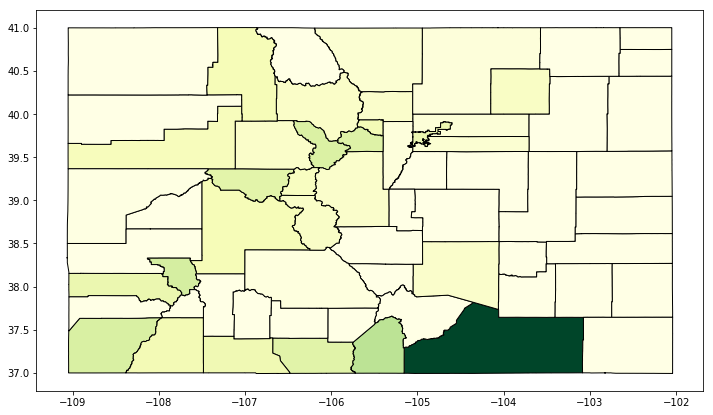

In [42]:
# plot on a map
retail_17_map.plot(column='per_capita',
                   edgecolor='black',
                   cmap='YlGn', 
                   figsize=(13,7))